# Single instance

In [1]:
# using Yao, QAOA, Random, Combinatorics, Arpack, Distributions, LinearAlgebra, , FFTW
using QAOA, Distributions, Interpolations
using HDF5, Printf
using PythonPlot
# PythonPlot.matplotlib.style.use("./paper.mplstyle")

PATH = "../";

In [2]:
using Revise, SpinFluctuations

In [3]:
Base.show(io::IO, f::Float64) = @printf(io, "%1.4f", f)

In [4]:
N = 9
pattern = r"random_SK_instance_N_9_seed_(\d+)\.h5"

# N = 19
# pattern = r"random_SK_instance_N_19_seed_(\d+)\.h5"

folder_name = PATH * @sprintf("data/")
instance_names = readdir(folder_name)

2-element Vector{String}:
 "random_SK_instance_N_9_seed_63685.h5"
 "results_random_SK_instance_N_9_seed_63685.h5"

In [5]:
# N = 9
#small 
# seed = 12778 # => 0.6085
# seed = 73014 # => 0.7356
# seed = 65343 # => 0.7854
# seed = 57220 # => 0.8052
# seed = 47297 # => 0.8217
# seed = 78653 # => 0.8303
# seed = 46944 # => 0.8403
# seed = 70592 # => 0.8467
# seed = 62565 # => 0.8595
# seed = 87929 # => 0.8867
# seed = 39879 # => 1.0371
seed = 63685 # => 1.2428

# N = 19
# small
# seed = 538 # => 0.4583
# seed = 628 # => 0.4771
# seed = 147 # => 0.5004
# seed = 63 # => 0.5323
# seed = 914 # => 0.5950
# seed = 863 # => 0.7336
# seed = 699 # => 0.7725
# seed = 1238 # => 0.7753
# seed = 18 # => 0.8269
# seed = 319 # => 0.8990 - GREAT ILLUSTRATION!
# seed = 674 # => 0.9061
# seed = 554 # => 1.0416


63685

In [6]:
h5open(folder_name * @sprintf("random_SK_instance_N_%i_seed_%i.h5", N, seed))

🗂️ HDF5.File: (read-only) ../data/random_SK_instance_N_9_seed_63685.h5
├─ 🔢 J
├─ 🔢 exact_ARPACK_LM_eigvals
└─ 🔢 exact_ARPACK_LM_lowest_eigvecs

In [7]:
# h5open(folder_name * @sprintf("results_random_SK_instance_N_%i_seed_%i.h5", N, seed))

In [8]:
J_mat = h5read(folder_name * @sprintf("random_SK_instance_N_%i_seed_%i.h5", N, seed), "J")
mf_problem = Problem(0, J_mat);

λ = h5read(folder_name * @sprintf("random_SK_instance_N_%i_seed_%i.h5", N, seed), "exact_ARPACK_LM_eigvals");

In [9]:
T_final = 32768
tol = 1e-8;

## Exact gap

In [10]:
exact_times = range(0, 1, 33);

In [11]:
gap = λ[2, :] .- λ[1, :];
mingap = minimum(gap) 
mingap |> println
gap_idx = findfirst(x -> x == mingap, gap) 
gaploc = exact_times[gap_idx] 
gaploc |> println

0.0055
0.7500


In [12]:
small_idxs = findall(x -> x < 0.05, gap ./ (2pi)) 
gap_interval = exact_times[small_idxs];

In [13]:
bogo_spec = h5read(folder_name * @sprintf("results_random_SK_instance_N_%i_seed_%i.h5", N, seed), @sprintf("bogoliubov_spectrum_T_final_%.0f_tol_1e%.0f_npts_%i", T_final, log10(tol), 32));

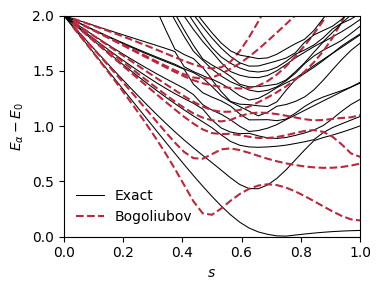

In [56]:
figure(figsize=(4, 3))
subplot(111)
for i in 1:size(bogo_spec)[1]
    plot(exact_times[2:end], bogo_spec[i, :], "--C1", lw=1.5, alpha=1, ms=2)
    plot(exact_times, (λ[i, :] .- λ[1, :]), "-k", lw=0.75, alpha=1, ms=2)    
end
# axvline(gap_interval[1], c="C0")
# axvline(gap_interval[end], c="C0")
plot([], [], "-k", lw=0.75, label="Exact")
plot([], [], "--C1", lw=1.5, label="Bogoliubov")
xlim(0., 1.)
ylim(-0., 2)
xlabel("\$s\$")
ylabel("\$E_\\alpha - E_0\$")
legend(frameon=false)
tight_layout()
display(gcf())

### Eigenstates

In [15]:
all_eigvecs = h5read(folder_name * @sprintf("random_SK_instance_N_%i_seed_%i.h5", N, seed), "exact_ARPACK_LM_lowest_eigvecs");

In [16]:
H_x = SpinFluctuations.hamiltonian(1, 0, mf_problem.local_fields, mf_problem.couplings)
H_z = SpinFluctuations.hamiltonian(0, 1, mf_problem.local_fields, mf_problem.couplings);

In [17]:
gs = [all_eigvecs[k, :, 1] for k in 1:length(exact_times)]
first_ex = [all_eigvecs[k, :, 2] for k in 1:length(exact_times)]
second_ex = [all_eigvecs[k, :, 3] for k in 1:length(exact_times)]

overlap_01_x = [first_ex[k]' * H_x * gs[k] for k in 1:length(exact_times)]
overlap_01_z = [first_ex[k]' * H_z * gs[k] for k in 1:length(exact_times)]

overlap_02_x = [second_ex[k]' * H_x * gs[k] for k in 1:length(exact_times)]
overlap_02_z = [second_ex[k]' * H_z * gs[k] for k in 1:length(exact_times)];

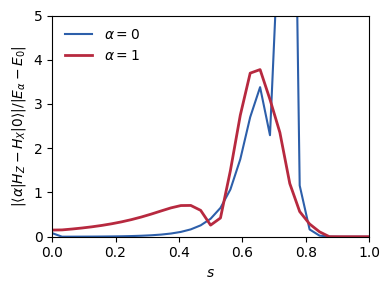

In [52]:
# PyPlot.rc("axes", prop_cycle=PyPlot.plt.cycler(color=["#2D5FAA", "#B7293F", "#438E6A", "#F7BD2E", "#F16C37"]))
PythonPlot.rc("axes", prop_cycle=PythonPlot.matplotlib.cycler(color=["#2D5FAA", "#B7293F", "#438E6A", "#F7BD2E", "#F16C37"]))
figure(figsize=(4, 3))
ax = subplot(111)
plot(exact_times, abs.(overlap_01_z .- overlap_01_x) ./ ((λ[2, :] .- λ[1, :])), label="\$\\alpha = 0\$")
plot(exact_times, abs.(overlap_02_z .- overlap_02_x) ./ ((λ[3, :] .- λ[1, :])), label="\$\\alpha = 1\$", lw=2)
xlim(0., 1.)
ylim(0, 5)
xlabel("\$s\$")
ylabel("\${|\\langle \\alpha|H_Z-H_X|0\\rangle|}/{|E_\\alpha - E_0|}\$")

legend(frameon=false)

tight_layout()
display(gcf())
PythonPlot.close();

#### Old

In [19]:
# figure(figsize=(7, 5))
# ax = subplot(221)
# # plot(exact_times, abs.(overlap_01_x), label="\$X\$")
# # plot(exact_times, abs.(overlap_01_z), label="\$Z\$")
# plot(exact_times, abs.(overlap_01_z .- overlap_01_x), label="\$|\\langle 1|H_Z-H_X|0\\rangle|\$")
# axvline(gap_interval[1], c="k")
# axvline(gaploc, c="C3")
# axvline(gap_interval[end], c="k")
# xlim(0., 1.)
# # ylim(-0., 0.5)
# ax.set_xticklabels([])
# ylabel("Numerator Adiab. Thm.")
# legend(frameon=false)

# ax = subplot(222)
# plot(exact_times, abs.(overlap_01_z .- overlap_01_x) ./ ((λ[2, :] .- λ[1, :])))
# # semilogy(exact_times, abs.(overlap_01_z .- overlap_01_x) ./ ((λ[2, :] .- λ[1, :])))
# axvline(gap_interval[1], c="k")
# axvline(gaploc, c="C3")
# axvline(gap_interval[end], c="k")
# xlim(0., 1.)
# ylim(0, )
# ax.set_xticklabels([])
# ylabel("Adiab. Thm.")


# ax = subplot(223)

# # plot(exact_times, abs.(overlap_02_x), "-", label="\$X\$")
# # plot(exact_times, abs.(overlap_02_z), "-", label="\$Z\$")
# plot(exact_times, abs.(overlap_02_z .- overlap_02_x), label="\$|\\langle 1|H_Z-H_X|0\\rangle|\$")

# axvline(gap_interval[1], c="k")
# axvline(gaploc, c="C3")
# axvline(gap_interval[end], c="k")
# xlim(0., 1.)
# # ylim(-0., 0.5)
# xlabel("\$s\$")
# ylabel("Numerator Adiab. Thm.")
# legend(frameon=false)

# ax = subplot(224)
# plot(exact_times, abs.(overlap_02_z .- overlap_02_x) ./ ((λ[3, :] .- λ[1, :])))
# axvline(gap_interval[1], c="k")
# axvline(gaploc, c="C3")
# axvline(gap_interval[end], c="k")
# xlim(0., 1.)
# # ylim(1e-6, 1e0)
# xlabel("\$s\$")
# ylabel("Adiab. Thm.")

# tight_layout()
# display(gcf())

## Mean-field trajectories

In [19]:
T_final = 32768.
tol = 1e-6;

In [20]:
sol_t = h5read(folder_name * @sprintf("results_random_SK_instance_N_%i_seed_%i.h5", N, seed), @sprintf("mean_field_T_final_%.0f_tol_1e%.0f/times", T_final, log10(tol)))
sol_u = h5read(folder_name * @sprintf("results_random_SK_instance_N_%i_seed_%i.h5", N, seed), @sprintf("mean_field_T_final_%.0f_tol_1e%.0f/trajectories", T_final, log10(tol)));

In [21]:
size(sol_u)

(74963, 3, 8)

In [22]:
component_dict = Dict("x" => 1, "y" => 2, "z" => 3)
nx_vals = reduce(hcat, [sol_u[k, component_dict["x"], :] for k in 1:size(sol_u)[1]])
ny_vals = reduce(hcat, [sol_u[k, component_dict["y"], :] for k in 1:size(sol_u)[1]])
nz_vals = reduce(hcat, [sol_u[k, component_dict["z"], :] for k in 1:size(sol_u)[1]]);

In [23]:
areas = Dict()
dts = [(x[2] - x[1]) / T_final for x in zip(sol_t[1:end-1], sol_t[2:end])]
for spin_idx in 1:N-1
    areas[spin_idx] = sum(dts .* nz_vals[spin_idx, 2:end]) |> abs
end

top_idxs = [k for (k, v) in sort(areas |> collect, by=x->x[2])]
top_idx = top_idxs[1]

5

In [25]:
regular_trajectories = filter!(x -> x != top_idxs[1], collect(1:N-1));

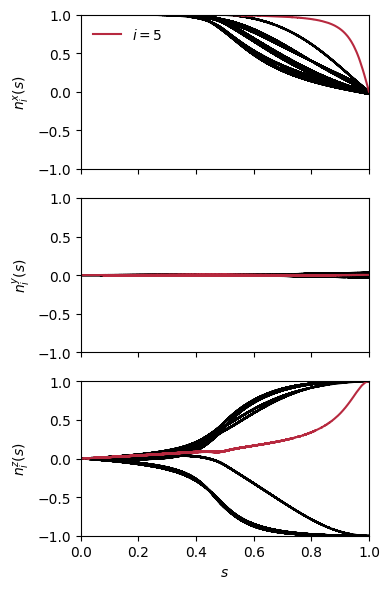

In [53]:
figure(figsize=(4, 6))

ax = subplot(311)
for spin_nr in regular_trajectories
    plot(sol_t ./ T_final, nx_vals[spin_nr, :], "-", c="k")    
end
plot(sol_t ./ T_final, nx_vals[top_idx, :], "-", c="C1", label=@sprintf("\$i=%i\$", top_idx))
xlim(0, 1)
ax.set_xticklabels([])
ylim(-1, 1)
ylabel("\$n_i^x(s)\$")
legend(frameon=false, ncol=2)

ax = subplot(312)
for spin_nr in regular_trajectories
    plot(sol_t ./ T_final, ny_vals[spin_nr, :], "-", c="k")    
end
plot(sol_t ./ T_final, ny_vals[top_idx, :], "-", c="C1", label=@sprintf("\$i=%i\$", top_idx))
xlim(0, 1)
ax.set_xticklabels([])
ylim(-1, 1)
ylabel("\$n_i^y(s)\$")
# legend(frameon=false, ncol=2)

ax = subplot(313)
for spin_nr in regular_trajectories
    plot(sol_t ./ T_final, nz_vals[spin_nr, :], "-", c="k")    
end
plot(sol_t ./ T_final, nz_vals[top_idx, :], "-", c="C1", label=@sprintf("\$i=%i\$", top_idx))
xlim(0, 1)
ylim(-1, 1)
xlabel("\$s\$")
ylabel("\$n_i^z(s)\$")
# legend(frameon=false, ncol=2)

tight_layout()
display(gcf())
# savefig("../plots/" * @sprintf("mean_field_max2sat_typical_instance_%04i_from_arxiv_2206_06876_N_%i_num_clauses_%i.pdf", idx, N, num_clauses), dpi=256, bbox_inches="tight")
PythonPlot.close();

In [27]:
# sigma_star = sign.(sol.u[end][3, :])
sigma_star = sign.(sol_u[end, 3, :])
h = mf_problem.local_fields
J = mf_problem.couplings
E = sum([-h[l] * sigma_star[l] for l in 1:N-1]) + sum([-J[i, j] * sigma_star[i] * sigma_star[j] for i in 1:N-1 for j in (i+1):N-1])

-3.6798

In [28]:
for spin_idx in 1:N-1
    # sigma_star_flip = sign.(sol.u[end][3, :])
    sigma_star_flip = sign.(sol_u[end, 3, :])
    sigma_star_flip[spin_idx] = (-1) * sigma_star_flip[spin_idx]
    E_flip = sum([-h[l] * sigma_star_flip[l] for l in 1:N-1]) + sum([-J[i, j] * sigma_star_flip[i] * sigma_star_flip[j] for i in 1:N-1 for j in (i+1):N-1])
    println(spin_idx, ": ", E_flip)
end

1: -3.0185
2: -2.5804
3: -1.4549
4: -0.9535
5: -3.5327
6: -2.9580
7: -1.2098
8: -0.6528


In [94]:
λ[1, :][end]

-4.9225

## Statistical Green function

In [ ]:
tol = 1e-8
T_final = 32000.
npts = 2048

T_final = 32768.
npts = 4096
coarse_times = range(0, 1, npts + 1);

In [ ]:
# lyapunov_parameters = LyapunovParameters(T_final, npts, 1e-4, 1e-6)
# mf_sol, stat_GF = statistical_green_function(mf_problem, lyapunov_parameters);
# flucs = k -> (real.(1.0im .* diag(stat_GF[k])[1:mf_problem.num_qubits]) .- 1.0) ./ 2
# all_flucs = reduce(hcat, map(flucs, 1:npts+1));

In [ ]:
# F = evolve_statistical_function(mf_problem, LyapunovParameters(T_final, npts, 1e-6, 1e-6))

In [ ]:
mapped_F = F[1].(T_final .* coarse_times)
new_all_flucs = [(real.(1.0im .* diag(mapped_F[k])[1:mf_problem.num_qubits]) .- 1.0) ./ 2 for k in 1:npts+1]
new_all_flucs = reduce(hcat, new_all_flucs);

In [ ]:
all_flucs = h5read(folder_name * @sprintf("results_random_SK_instance_N_%i_seed_%i.h5", N, seed), @sprintf("fluctuations_T_final_%.0f_tol_1e%.0f_npts_%i", T_final, log10(1e-8), npts));

In [ ]:
function moving_average(vs, n)
    res = similar(vs, length(vs) - (n-1))
    @inbounds for i in 1:length(res)
        res[i] = sum(@view vs[i:(i + n-1)]) / n
    end
    return res
end

function smoothen(data, coarse_times; navg=64)
    ninterp = size(coarse_times)[1] - 1
    avg_data = linear_interpolation(range(0, 1, ninterp + 1)[1:end - navg + 1], moving_average(data, navg), extrapolation_bc=Line())
    map(x -> avg_data(x - navg / 2ninterp), coarse_times)
end

In [ ]:
figure(figsize=(8, 2))
subplot(131)
plot(coarse_times, mean(all_flucs, dims=1)[1, :])
# plot(coarse_times, smoothen(mean(all_flucs, dims=1)[1, :], coarse_times))

# plot(coarse_times, mean(new_all_flucs, dims=1)[1, :])

# for idx in top_idxs[1:1]
#     plot(coarse_times, new_all_flucs[idx, :] .- mean(new_all_flucs, dims=1)[1, :])
#     plot(coarse_times, all_flucs[idx, :] .- mean(all_flucs, dims=1)[1, :])
# end
axvline(gaploc, c="r")
axvline(gap_interval[1], c="k")
axvline(gap_interval[end], c="k")

subplot(132)
plot(coarse_times, sum([(all_flucs[top_idxs[k], :] .- mean(all_flucs, dims=1)[1, :]) ./ maximum(all_flucs[top_idxs[k], :]) for k in 1:2]))
axvline(gaploc, c="r")
axvline(gap_interval[1], c="k")
axvline(gap_interval[end], c="k")
ylim(0, )

subplot(133)
plot(coarse_times, all_flucs[top_idxs[1], :] .- mean(all_flucs, dims=1)[1, :])
plot(coarse_times, all_flucs[top_idxs[2], :] .- mean(all_flucs, dims=1)[1, :])
axvline(gaploc, c="r")
axvline(gap_interval[1], c="k")
axvline(gap_interval[end], c="k")
ylim(0, )
tight_layout()
display(gcf())

In [ ]:
figure(figsize=(20, 4))
ylims = (-0.0, ) # 0.25
for i in 1:(N-1)÷2
    ax = subplot(2, (N-1)÷2, i)
    # plot(coarse_times, all_flucs[i, :], label=@sprintf("\$i=%s\$", string(i)))
    c = "C0"
    if i in top_idxs[1:3]
        c = "C3"
    end
    plot(coarse_times, all_flucs[i, :] .- mean(all_flucs, dims=1)[1, :], label=@sprintf("\$i=%s\$", string(i)), c=c)
    plot(coarse_times, smoothen(all_flucs[i, :], coarse_times) .- mean(all_flucs, dims=1)[1, :], label=@sprintf("\$i=%s\$", string(i)), c="k")
    axvline(gaploc, c="r")
    axvline(gap_interval[1], c="k")
    axvline(gap_interval[end], c="k")
    xlim(0., 1.)
    ax.set_xticklabels([])
    ylim(ylims...)
    if i > 1
        ax.set_yticklabels([])
    end
    legend(frameon=false, ncol=2, handlelength=0)
end

ax = subplot(2, (N-1)÷2, 1)
ax.set_ylabel("\$F_{ii}(t, t)\$")

for i in (N-1)÷2+1:N-1
    ax = subplot(2, (N-1)÷2, i)
    # plot(coarse_times, all_flucs[i, :], label=@sprintf("\$i=%s\$", string(i)))
    c = "C0"
    if i in top_idxs[1:3]
        c = "C3"
    end
    plot(coarse_times, all_flucs[i, :] .- mean(all_flucs, dims=1)[1, :], label=@sprintf("\$i=%s\$", string(i)), c=c)
    plot(coarse_times, smoothen(all_flucs[i, :], coarse_times) .- mean(all_flucs, dims=1)[1, :], label=@sprintf("\$i=%s\$", string(i)), c="k")
    axvline(gaploc, c="r")    
    axvline(gap_interval[1], c="k")
    axvline(gap_interval[end], c="k")
    xlim(0., 1.)
    ylim(ylims...)
    if i > (N-1)÷2+1
        ax.set_yticklabels([])
    end    
    xlabel("\$s\$")    
    legend(frameon=false, ncol=2, handlelength=0)
end

ax = subplot(2, (N-1)÷2, (N-1)÷2 + 1)
ax.set_ylabel("\$F_{ii}(t, t)\$")

tight_layout()
display(gcf())
# savefig("../plots/" * @sprintf("fluctuations_max2sat_typical_instance_%04i_from_arxiv_2206_06876_N_%i_num_clauses_%i.pdf", idx, N, num_clauses), dpi=256, bbox_inches="tight")

In [ ]:
figure(figsize=(20, 4))
ylims = () #(-0.0, 0.1) # 0.25
for i in 1:(N-1)÷2
    ax = subplot(2, (N-1)÷2, i)
    plot(coarse_times, all_flucs[i, :], label=@sprintf("\$i=%s\$", string(i)))
    # plot(coarse_times, all_flucs[i, :] .- mean(all_flucs, dims=1)[1, :], label=@sprintf("\$i=%s\$", string(i)))
    axvline(gaploc, c="r")
    axvline(gap_interval[1], c="k")
    axvline(gap_interval[end], c="k")
    xlim(0., 1.)
    ax.set_xticklabels([])
    ylim(ylims...)
    # if i > 1
    #     ax.set_yticklabels([])
    # end
    legend(frameon=false, ncol=2, handlelength=0)
end

ax = subplot(2, (N-1)÷2, 1)
ax.set_ylabel("\$F_{ii}(t, t)\$")

for i in (N-1)÷2+1:N-1
    ax = subplot(2, (N-1)÷2, i)
    plot(coarse_times, all_flucs[i, :], label=@sprintf("\$i=%s\$", string(i)))
    # plot(coarse_times, all_flucs[i, :] .- mean(all_flucs, dims=1)[1, :], label=@sprintf("\$i=%s\$", string(i)))
    axvline(gaploc, c="r")    
    axvline(gap_interval[1], c="k")
    axvline(gap_interval[end], c="k")
    xlim(0., 1.)
    ylim(ylims...)
    # if i > (N-1)÷2+1
    #     ax.set_yticklabels([])
    # end    
    xlabel("\$s\$")    
    legend(frameon=false, ncol=2, handlelength=0)
end

ax = subplot(2, (N-1)÷2, (N-1)÷2 + 1)
ax.set_ylabel("\$F_{ii}(t, t)\$")

tight_layout()
display(gcf())
# savefig("../plots/" * @sprintf("fluctuations_max2sat_typical_instance_%04i_from_arxiv_2206_06876_N_%i_num_clauses_%i.pdf", idx, N, num_clauses), dpi=256, bbox_inches="tight")

## Spectra

In [30]:
T_final = 32768.
tol = 1e-6
τ_final = 2048.

npts_diag = 16
T_diags = T_final .* range(0.5, 1.0, npts_diag+1)

ωs = []
spec_sum = []
for k in 1:17
    push!(ωs, h5read(folder_name * "results_" * @sprintf("random_SK_instance_N_%i_seed_%i.h5", N, seed), @sprintf("spectra_T_final_%i_tau_final_%i/T_%0.5f/omegas", T_final, τ_final, T_diags[k] / T_final)))
    push!(spec_sum, h5read(folder_name * "results_" * @sprintf("random_SK_instance_N_%i_seed_%i.h5", N, seed), @sprintf("spectra_T_final_%i_tau_final_%i/T_%0.5f/data", T_final, τ_final, T_diags[k] / T_final)))
end   

In [31]:
t_idx = 8
println(T_diags[t_idx] ./ T_final)

0.7188


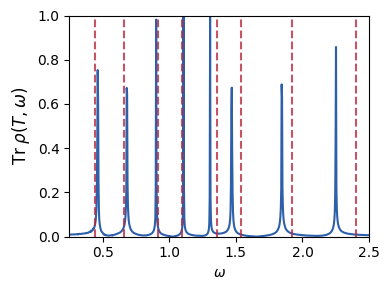

In [54]:
figure(figsize=(4, 3))
ax = subplot(111)
for k in [t_idx]
    plot(2pi .* ωs[k], spec_sum[k])
end
axvline.(bogo_spec[N:end, 16 + t_idx], c="C1", alpha=0.8, ls="--", lw=1.5)
xlim(0.25, 2.5)
ylim(-0., 1)
xlabel("\$\\omega\$")
ylabel("\$\\mathrm{Tr}\\;{\\rho}(T, \\omega)\$", fontsize=12)
tight_layout()
display(gcf())
PythonPlot.close();